In [2]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 876.5 kB/s eta 0:00:0000:0100:01


In [88]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Zadanie 1

Zbiór danych: `zamowienia.csv`

Bazując na przykładzie z wykresem plotly typu sunburst dla dwóch cech: `Kraj` oraz `Sprzedawca` stwórz wykresy tego samego typu:
* z rozkładem wartości dla cechy `Kraj` oraz roku z cechy `Data zamowienia`
* z rozkładem wartości dla cechy `Sprzedawca` oraz roku z cechy `Data zamowienia`
* z rozkładem wartości dla cechy `Kraj`, roku oraz `Sprzedawcy`.

Dla ułatwienia całej operacji stwórz w ramce danych kolumnę, która zawierać będzie wartość `year` z kolumny `Data zamowienia` (w komórce, w której zbiór został wczytany została skonwertowana na typ datetime).

In [13]:
df = pd.read_csv('data/zamowienia.csv', sep=';')
df['Data zamowienia'] = pd.to_datetime(df['Data zamowienia'])
df['rok'] = df['Data zamowienia'].dt.year
df.head()

,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg,rok
0,Polska,Kowalski,2003-07-16,10248,440.00,2003
1,Polska,Sowiński,2003-07-10,10249,1863.40,2003
2,Niemcy,Peacock,2003-07-12,10250,1552.60,2003
3,Niemcy,Leverling,2003-07-15,10251,654.06,2003
4,Niemcy,Peacock,2003-07-11,10252,3597.90,2003


In [14]:
fig1 = px.sunburst(df, path=['Kraj', 'rok'], values='Utarg', title='Rozkład Utargu wg Kraju i Roku')
fig1.show()

In [15]:
fig2 = px.sunburst(df, path=['Sprzedawca', 'rok'], values='Utarg', title='Rozkład Utargu wg Sprzedawcy i Roku')
fig2.show()

In [16]:
fig3 = px.sunburst(df, path=['Kraj', 'rok', 'Sprzedawca'], values='Utarg', title='Rozkład Utargu wg Kraju, Roku i Sprzedawcy')
fig3.show()

### Zadanie 2

Zbiór danych: EUROSTAT `DEMO_GIND` (ten sam co w przykładach).

Odpowiedz na poniższe pytania dotyczące powyższego zbioru:

Pamiętaj o odpowiedniej kolejności złączenia tych danych.


In [17]:
!pip install eurostat


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
import eurostat

#### 2.1 Jak wygląda wykres zmiany średniej liczby ludności (indic_de = AVG) dla strefy Euro (geo = EA19)?

In [30]:
data = eurostat.get_data_df('DEMO_GIND')
data = data.rename(columns={r'geo\TIME_PERIOD': 'geo'})

In [71]:
df_melted = data.melt(id_vars=['freq','indic_de', 'geo'], var_name='time', value_name='value')
df_melted.head(10)

,freq,indic_de,geo,time,value
0,A,AVG,AD,1960,NaN
1,A,AVG,AL,1960,1608800.0
2,A,AVG,AM,1960,NaN
3,A,AVG,AT,1960,7047539.0
4,A,AVG,AZ,1960,NaN
5,A,AVG,BA,1960,3238989.0
6,A,AVG,BE,1960,9153489.0
7,A,AVG,BG,1960,7867374.0
8,A,AVG,BY,1960,NaN
9,A,AVG,CH,1960,5327827.0


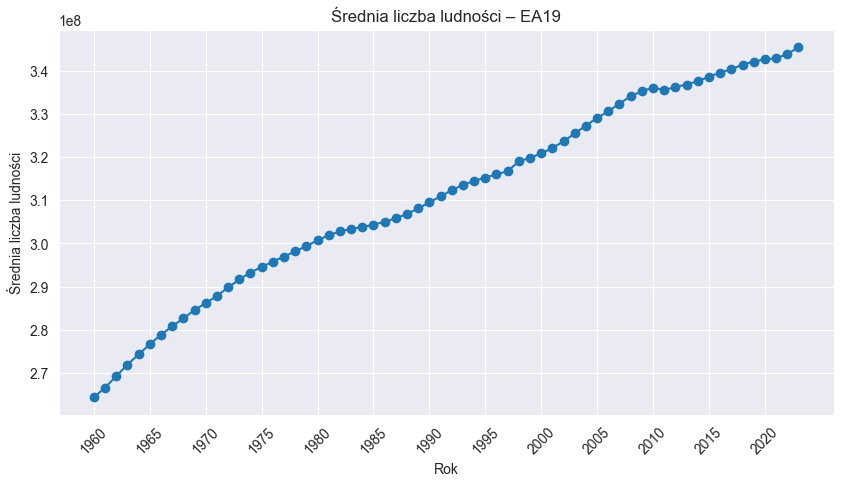

In [111]:
df_avg_ea19 = df_melted[(df_melted['geo'] == 'EA19') & (df_melted['indic_de'] == 'AVG')]
df_avg_ea19 = df_avg_ea19.groupby('time')['value'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_avg_ea19['time'], df_avg_ea19['value'], marker='o')
plt.title('Średnia liczba ludności – EA19')
plt.xlabel('Rok')
plt.ylabel('Średnia liczba ludności')
plt.xticks(ticks=df_avg_ea19['time'][::5], rotation=45)
plt.grid(True)
plt.show()

#### 2.2 Jak wygląda wskaźnik śmiertelności dla Polski w porównaniu z tym samym wskaźnikiem dla Niemiec, Czech, Francji oraz Szwecji? Wyświetl dane w postaci wykresu liniowego dla wielu serii.

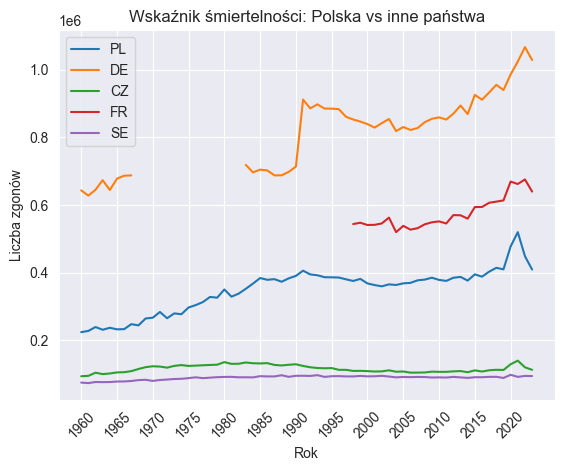

In [118]:
countries = ['PL', 'DE', 'CZ', 'FR', 'SE']
df_deaths = df_melted[(df_melted['geo'].isin(countries)) & (df_melted['indic_de'] == 'DEATH')]

for country in countries:
    df_country = df_deaths[df_deaths['geo'] == country]
    plt.plot(df_country['time'], df_country['value'], label=country)

plt.title('Wskaźnik śmiertelności: Polska vs inne państwa')
plt.xlabel('Rok')
plt.ylabel('Liczba zgonów')
plt.legend()
plt.xticks(ticks=df_avg_ea19['time'][::5], rotation=45)
plt.grid(True)
plt.show()

#### 2.3 Jak wygląda struktura ludności 20 najludniejszych państw Unii Europejskiej za rok 2023? Dane wyświetl na wykresie kołowym z wykorzystaniem biblioteki plotly.


In [108]:
df_2023 = df_melted[(df_melted['time'] == '2023') & (df_melted['indic_de'] == 'POPT')]

top20 = df_2023.sort_values(by='value', ascending=False).head(20)

In [109]:
fig = px.pie(top20, names='geo', values='value', title='Struktura ludności 20 najludniejszych państw UE – 2023')
fig.show()

#### 2.4 Które 3 państwa mają najbardziej zbliżoną liczbę ludności do Polski biorąc pod uwagę rok 2023?


In [86]:
df_2023_pop = df_melted[(df_melted['time'] == '2023') & (df_melted['indic_de'] == 'POPT')].copy()

polska_value = df_2023_pop[df_2023_pop['geo'] == 'PL']['value'].values[0]

df_2023_pop['diff'] = abs(df_2023_pop['value'] - polska_value)

df_close = df_2023_pop[df_2023_pop['geo'] != 'PL'].sort_values(by='diff').head(3)

In [87]:
df_close[['geo', 'value']]

,geo,value
99776,RO,979638.0
99750,EFTA,767715.0
99772,NL,717841.0


#### 2.5 Wyświetl wykres liniowy porównujący liczbę narodzin i śmierci (wykorzystaj bibliotekę plotly) dla Unii Europejskiej w latach 2007-2023. Tutaj należy złączyć dane z trzech cech geo w jeden wektor:

* [EU27_2020] - European Union - 27 countries (from 2020)
* [EU28] European Union - 28 countries (2013-2020)
* [EU27_2007] European Union - 27 countries (2007-2013)

In [119]:
geo_eu = ['EU27_2007', 'EU28', 'EU27_2020']
indic = ['BIRTH', 'DEATH']

df_eu = df_melted[(df_melted['geo'].isin(geo_eu)) & (df_melted['indic_de'].isin(indic))]

df_eu_combined = pd.DataFrame()
for geo in geo_eu:
    sub = df_eu[df_eu['geo'] == geo]
    df_eu_combined = pd.concat([df_eu_combined, sub])

df_plot = df_eu_combined.groupby(['time', 'indic_de'])['value'].sum().reset_index()
df_births = df_plot[df_plot['indic_de'] == 'BIRTH']
df_deaths = df_plot[df_plot['indic_de'] == 'DEATH']

In [121]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_births['time'], y=df_births['value'],
                         mode='lines+markers', name='Narodziny'))
fig.add_trace(go.Scatter(x=df_deaths['time'], y=df_deaths['value'],
                         mode='lines+markers', name='Zgony'))

fig.update_layout(title='Liczba narodzin i zgonów w UE (2007–2023)',
                  xaxis_title='Rok', yaxis_title='Liczba osób', xaxis=dict(tickangle=-45))
fig.show()

### Zadanie 3


**3.1** Wyświetl różnicę liczby ludności zarejestrowanej w styczniu każdego roku dla pierwszego i ostatniego pomiaru dla każdej wartości w kolumnie `geo`. Wartość wyświetl w postaci nominalnej i procentowej.


\* raczej dość trudne

In [92]:
df_melted['indic_de'] = df_melted['indic_de'].str.strip().str.upper()
df_melted['time'] = df_melted['time'].astype(str).str.strip()
df_melted['value'] = pd.to_numeric(df_melted['value'], errors='coerce')
df_melted['geo'] = df_melted['geo'].str.strip().str.upper()

df_jan = df_melted[df_melted['indic_de'] == 'JAN'].copy()

df_jan['time'] = df_jan['time'].astype(int)

first_last = df_jan.sort_values(by='time').groupby('geo').agg(
    first_year=('time', 'first'),
    last_year=('time', 'last'),
    first_value=('value', 'first'),
    last_value=('value', 'last')
).reset_index()

# Oblicz różnicę nominalną i procentową
first_last['diff_nominal'] = first_last['last_value'] - first_last['first_value']
first_last['diff_percent'] = (first_last['diff_nominal'] / first_last['first_value']) * 100

In [99]:
first_last.head()

,geo,first_year,last_year,first_value,last_value,diff_nominal,diff_percent
0,AD,1960,2024,44593.0,85101.0,40508.0,90.839369
1,AL,1960,2024,1583800.0,2761785.0,1177985.0,74.377131
2,AM,1960,2024,3248800.0,2991201.0,-257599.0,-7.929051
3,AT,1960,2024,7030385.0,9158750.0,2128365.0,30.273804
4,AZ,1960,2024,7726200.0,10180770.0,2454570.0,31.769434


**3.2** W którym Państwie nastąpiła największa zmiana liczby ludności (odrzuć wartości w kolumnie `geo`, które nie wskazują na jedno konkretne państwo)?

In [100]:
first_last_countries = first_last[first_last['geo'].str.len() == 2].copy()

max_change = first_last_countries.loc[first_last_countries['diff_nominal'].abs().idxmax()]

max_change[['geo', 'first_value', 'last_value', 'diff_nominal', 'diff_percent']]

geo                     TR
first_value     27119962.0
last_value      85372377.0
diff_nominal    58252415.0
diff_percent    214.795342
Name: 55, dtype: object